<a href="https://colab.research.google.com/github/ncduy0303/Competitive-Programming/blob/master/MNIST_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 1) Import the necessary libraries:

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
import os
from PIL import Image

In [0]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

#### 2) Defining constants:

In [0]:
# Define some constants
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 100

#### 3) Define the generator model:

In [0]:
def generator_model():
  model = Sequential()
  model.add(Dense(128 * 7 * 7, input_dim = latent_dim, activation = LeakyReLU(0.1)))
  model.add(BatchNormalization())
  model.add(Reshape((7, 7, 128)))
  model.add(UpSampling2D())
  model.add(Conv2D(64, (5, 5), padding = 'same', activation = LeakyReLU(0.1)))
  model.add(BatchNormalization())
  model.add(UpSampling2D())
  model.add(Conv2D(channels, (5, 5), padding = 'same', activation = 'tanh'))

  model.summary()

  noise = Input(shape=(latent_dim,))
  img = model(noise)

  return Model(noise, img)

#### 4) Define the discriminator model:

In [0]:
def discriminator_model():
  model = Sequential()
  model.add(Conv2D(64, (5, 5), padding = 'same', strides = 2, activation = LeakyReLU(0.1), input_shape = input_dim))
  model.add(Dropout(0.3))
  model.add(Conv2D(128, (5, 5), padding = 'same', strides = 2, activation = LeakyReLU(0.1)))
  model.add(Dropout(0.3))
  model.add(Flatten())
  model.add(Dense(1, activation = 'sigmoid'))

  model.summary()

  img = Input(shape=img_shape)
  validity = model(img)

  return Model(img, validity)

#### 5) Compile both the generator and the discriminator with the Adam optimizer:

In [85]:
# Build the generator
generator_model = generator_model()
#generator_model.compile(loss = 'binary_crossentropy', optimizer = Adam())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 6272)              633472    
_________________________________________________________________
batch_normalization_12 (Batc (None, 6272)              25088     
_________________________________________________________________
reshape_6 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_12 (UpSampling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_13 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
up_sampling2d_13 (UpSampling (None, 28, 28, 64)      

In [86]:
# Build the discriminator
discriminator_model = discriminator_model()
discriminator_model.compile(loss = 'binary_crossentropy', optimizer = Adam(), metrics=['accuracy'])

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_11 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 6273      
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
_______________________________________________

In [87]:
# Combine both the generator and the discriminator

generator_input = Input(shape = (latent_dim, ))
generator_output = generator_model(generator_input)

# For the combined model we will only train the generator
discriminator_model.trainable = False

# The discriminator takes generated images as input and determines validity
discriminator_output = discriminator_model(generator_output)

adversarial_model = Model(inputs = generator_input, outputs = discriminator_output)
adversarial_model.compile(loss = 'binary_crossentropy', optimizer = Adam())
adversarial_model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
model_7 (Model)              (None, 28, 28, 1)         865281    
_________________________________________________________________
model_8 (Model)              (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


#### 6) Create a function to train the model:

In [0]:
def train(epochs, batch_size = 128, save_interval = 50):
    os.makedirs('images', exist_ok = True)
    
    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale to [-1, 1]
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis = 3)

    # Adversarial ground truths
    real = np.ones((batch_size, 1))
    gen = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # Select a random real images
        real_imgs = X_train[np.random.randint(0, X_train.shape[0], batch_size)]

        # Sample noise and generate a batch of fake images
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator_model.predict(noise)

        # Train the discriminator
        d_loss_real = discriminator_model.train_on_batch(real_imgs, real)
        d_loss_gen = discriminator_model.train_on_batch(gen_imgs, gen)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_gen)

        # Train the generator
        g_loss = adversarial_model.train_on_batch(noise, real)

        # If at save interval
        if epoch % save_interval == 0:
            # Print the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
            save_imgs(epoch)

In [0]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator_model.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()

In [0]:
start = time.time()

train(epochs = 10000, batch_size = 32, save_interval = 1000)

end = time.time()
elapsed_train_time = 'elapsed training time: {} min, {} sec '.format(int((end - start) / 60),
                                                                     int((end - start) % 60))
print(elapsed_train_time)

In [0]:
os.makedirs('saved_model_weights', exist_ok=True)
generator_model.save_weights('saved_model_weights/generator_model_weights.h5')
discriminator_model.save_weights('saved_model_weights/discriminator_model_weights.h5')
adversarial_model.save_weights('saved_model_weights/adversarial_model_weights.h5')

#### 7) Output some synthetic images using the trained model:

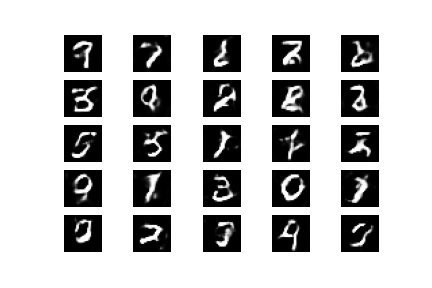

In [98]:
Image.open('images/mnist_1000.png')

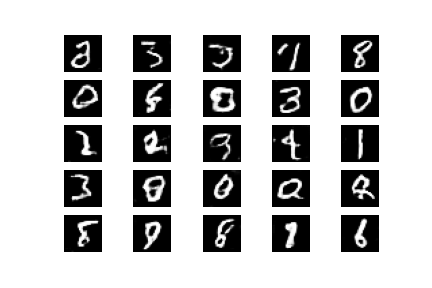

In [99]:
Image.open('images/mnist_9000.png')

In [0]:
def plot_output(text):
  # Random noise as the input
  try_input = np.random.rand(50, 100)
  predictions = generator_model.predict(try_input)

  plt.figure(figsize = (20, 20))
  for i in range(predictions.shape[0]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap = 'gray')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(text)

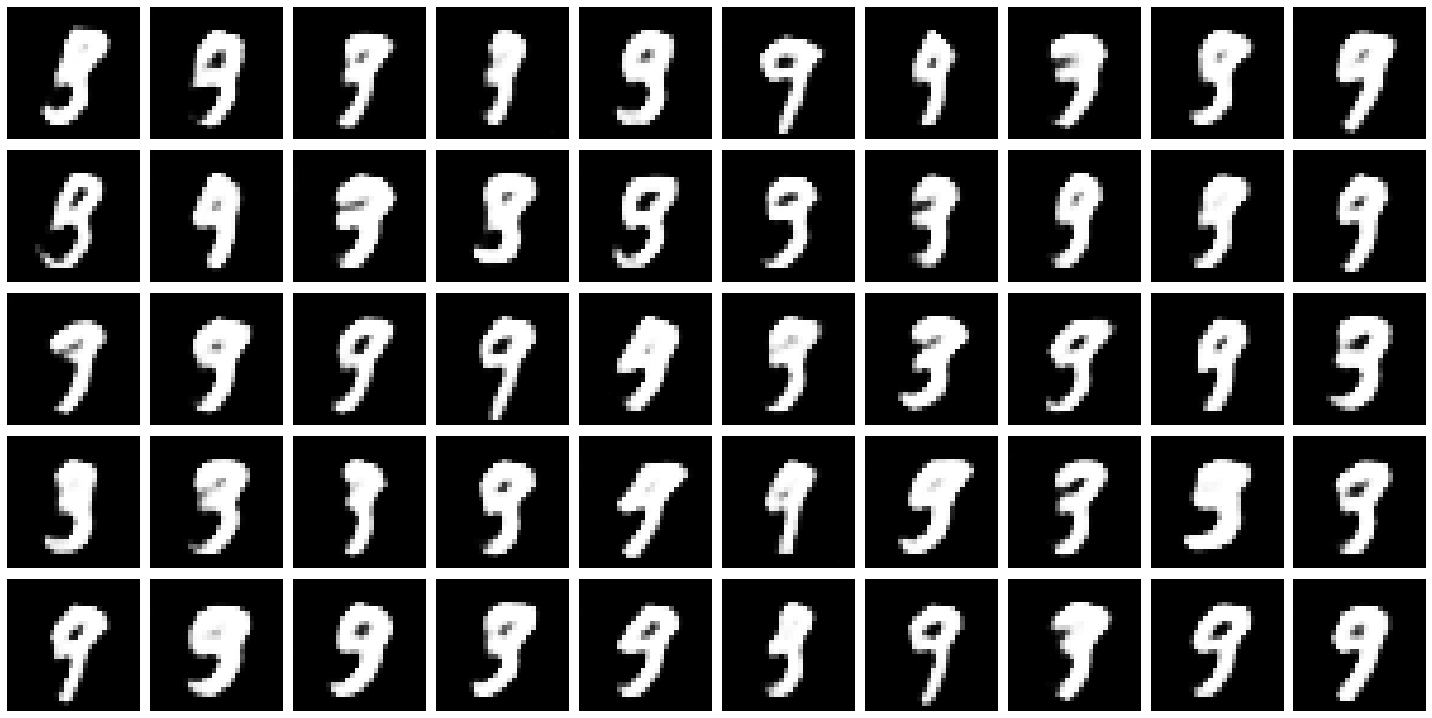

In [103]:
plot_output('80')